https://www.implementingquantlib.com/2023/09/ametrano-bianchetti.html

# Estr
The euro short-term rate (€STR) is a rate which reflects the wholesale euro
unsecured overnight borrowing costs of euro area banks. The rate is published for
each TARGET2 business day based on transactions conducted and settled on the
previous day (reporting date T) with a maturity date of T+1 and which are deemed to
be executed at arm’s length and thereby reflect market rates in an unbiased way

In [1]:
# import the used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
import BootStrapping as bs
import MarketData as md
import ReadExcel
import  math
import datetime as dt
import openpyxl 
import re
import refinitiv.data as rd

%matplotlib inline

In [2]:
# Setting evaluation date
today = ql.Date.todaysDate()
today = ql.TARGET().adjust(today,ql.Following)
ql.Settings.instance().setEvaluationDate(today)

# Market quotes

## Refinitiv

In [3]:

session = rd.session.desktop.Definition(app_key='256eae2f881c499095090ac71dc96aa92cc6cb90').get_session()
session.open()
rd.session.set_default(session)
 
EUROIS_chain = rd.content.pricing.chain.Definition(name='EUROIS=').get_stream()
EUROIS_chain.open(False)
euroOISwapQuotes = rd.get_data(universe=EUROIS_chain.constituents, fields=['GV4_TEXT', 'MATUR_DATE', 'PRIMACT_1', 'SEC_ACT_1'])
estrQuote    = rd.get_data(universe=['EUROSTR='], fields=['TRDPRC_1'] )


In [4]:
print(estrQuote)
euroOISwapQuotes

  Instrument  TRDPRC_1
0   EUROSTR=     3.906


,Instrument,GV4_TEXT,MATUR_DATE,PRIMACT_1,SEC_ACT_1
0,EUREONSW=,SW,2023-10-10,3.965,4.015
1,EUREON2W=,2W,2023-10-17,3.983,3.999
2,EUREON3W=,3W,2023-10-24,3.984,4.0
3,EUREON1M=,1M,2023-11-03,3.9893,4.0014
4,EUREON2M=,2M,2023-12-04,3.9995,4.0081
5,EUREON3M=,3M,2024-01-03,4.0111,4.0182
6,EUREON4M=,4M,2024-02-05,4.0276,4.0347
7,EUREON5M=,5M,2024-03-04,4.016,4.066
8,EUREON6M=,6M,2024-04-03,4.0415,4.0486
9,EUREON7M=,7M,2024-05-03,4.039,4.045


## File

In [5]:
#mdata = md.getMarketData("CurvesFromBB\EUR.OIS.xlsx",'Bcurve',['Term','InstType','InstDes','Mid','Frequency','DayCount'])
estrQuote

,Instrument,TRDPRC_1
0,EUROSTR=,3.906


## Plot raw quotes

<Axes: xlabel='YearFrac'>

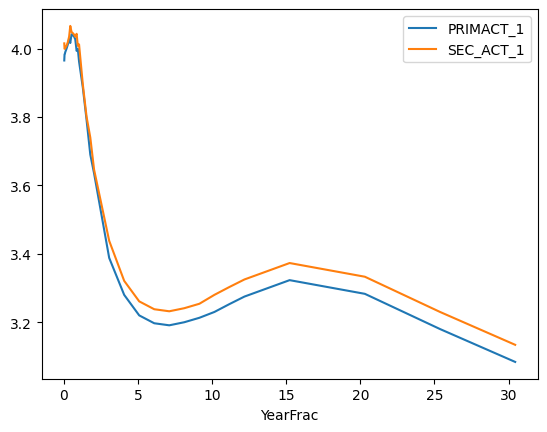

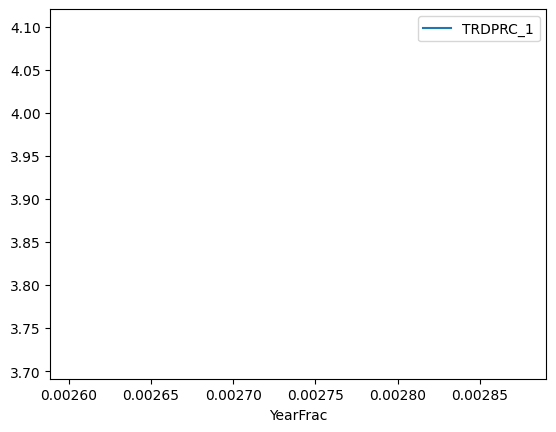

In [6]:
euroOISwapQuotes['YearFrac'] = euroOISwapQuotes['MATUR_DATE'].apply(lambda mat : ql.Actual360().yearFraction(today,ql.Date().from_date(mat)))
estrQuote['YearFrac'] = 1/365
euroOISwapQuotes['Spread'] = euroOISwapQuotes['SEC_ACT_1']- euroOISwapQuotes['PRIMACT_1']
euroOISwapQuotes[['YearFrac','PRIMACT_1','SEC_ACT_1']].set_index('YearFrac').plot()
estrQuote[['YearFrac','TRDPRC_1']].set_index('YearFrac').plot()

# Bootstrap zero yields and reprice instruments

In [7]:
oiSwap = [md.Datum(2,                        
                        md.map_RTRtenor_to_quantlib_period(row["GV4_TEXT"].strip()).units(),
                        md.map_RTRtenor_to_quantlib_period(row["GV4_TEXT"].strip()).length(),
                        (row["PRIMACT_1"]+row["SEC_ACT_1"]) /200) for index,row in euroOISwapQuotes.iterrows()]

estr = [md.Datum(0, ql.Days,1,row['TRDPRC_1']/100)                    
                         for index,row in estrQuote.iterrows()]

mdata = md.MarketData(estr,oiSwap,[])




In [8]:
mc = md.MarketConventions()
oisZeroYields = bs.BootstrapOIS(mdata,mc)
discountTermStructure = ql.RelinkableYieldTermStructureHandle()
discountTermStructure.linkTo(oisZeroYields)
forecastTermStructure = ql.RelinkableYieldTermStructureHandle()
forecastTermStructure.linkTo(oisZeroYields)
# swaps to be priced


In [9]:

swapEngine = ql.DiscountingSwapEngine(discountTermStructure)
def priceOISwap(numTermUnits,termUnit,index,mc):
    nominal = 1000000
    settlementDate = mc.calendar.advance(ql.Settings.instance().evaluationDate,mc.settlementDays,
                                        ql.Days,mc.floatingEoniaConvention)
    maturity = mc.calendar.advance(settlementDate,numTermUnits,termUnit,mc.fixedEoniaConvention)
    
  
    fixedLegAdjustment = mc.fixedEoniaConvention
    fixedLegDayCounter = mc.fixedEoniaDayCount
    fixedLegTenor = ql.Period(1,ql.Years)
    fixedRate = 0.0
  
    spread = 0.0    
    floatingLegAdjustment = mc.floatingEoniaConvention
    floatingLegDayCounter = mc.floatingEoniaDayCount
    floatingLegTenor = ql.Period(1,ql.Years)
   
    fixedSchedule = ql.Schedule(settlementDate, maturity,
                             fixedLegTenor, mc.calendar,
                             fixedLegAdjustment, fixedLegAdjustment,
                             ql.DateGeneration.Forward, False)
    floatingSchedule = ql.Schedule(settlementDate, maturity,
                                floatingLegTenor, mc.calendar,
                                floatingLegAdjustment, floatingLegAdjustment,
                                ql.DateGeneration.Forward, False)

    spot = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal,
                       fixedSchedule, fixedRate, fixedLegDayCounter,
                       floatingSchedule, index, spread,
                       floatingLegDayCounter)
    spot.setPricingEngine(swapEngine)
    return spot.NPV(),spot.fairRate(),spot.fairSpread()




## Roundtrip recover quoted par rates from zeroyields

In [10]:
oindex = ql.Eonia(forecastTermStructure)
for item in sorted (mdata.oiSwapQuotes, key = lambda item : ql.Period(item.numTimeUnits,item.timeUnit)):
    print("Market: " + md.printOISwapDatum(item,4)
    + ";Model: " + md.formatRate(priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1],4)
    + ";Error: " + md.formatRate(item.rate-priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1],4))

Market: Maturity: 1W	Quoted Rate:3.9900 %;Model: 3.9900 %;Error: -0.0000 %
Market: Maturity: 2W	Quoted Rate:3.9910 %;Model: 3.9910 %;Error: 0.0000 %
Market: Maturity: 3W	Quoted Rate:3.9920 %;Model: 3.9920 %;Error: 0.0000 %
Market: Maturity: 1M	Quoted Rate:3.9954 %;Model: 3.9954 %;Error: -0.0000 %
Market: Maturity: 2M	Quoted Rate:4.0038 %;Model: 4.0038 %;Error: -0.0000 %
Market: Maturity: 3M	Quoted Rate:4.0146 %;Model: 4.0147 %;Error: -0.0000 %
Market: Maturity: 4M	Quoted Rate:4.0312 %;Model: 4.0311 %;Error: 0.0000 %
Market: Maturity: 5M	Quoted Rate:4.0410 %;Model: 4.0410 %;Error: -0.0000 %
Market: Maturity: 6M	Quoted Rate:4.0450 %;Model: 4.0450 %;Error: 0.0000 %
Market: Maturity: 7M	Quoted Rate:4.0420 %;Model: 4.0420 %;Error: -0.0000 %
Market: Maturity: 8M	Quoted Rate:4.0380 %;Model: 4.0380 %;Error: -0.0000 %
Market: Maturity: 9M	Quoted Rate:4.0309 %;Model: 4.0309 %;Error: -0.0000 %
Market: Maturity: 10M	Quoted Rate:4.0180 %;Model: 4.0180 %;Error: -0.0000 %
Market: Maturity: 11M	Quoted

C:\Users\fhoefer\AppData\Local\Temp\ipykernel_32644\3600953350.py:13:UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
C:\Users\fhoefer\AppData\Local\Temp\ipykernel_32644\3600953350.py:14:UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


Text(0.5, 1.0, ' ')

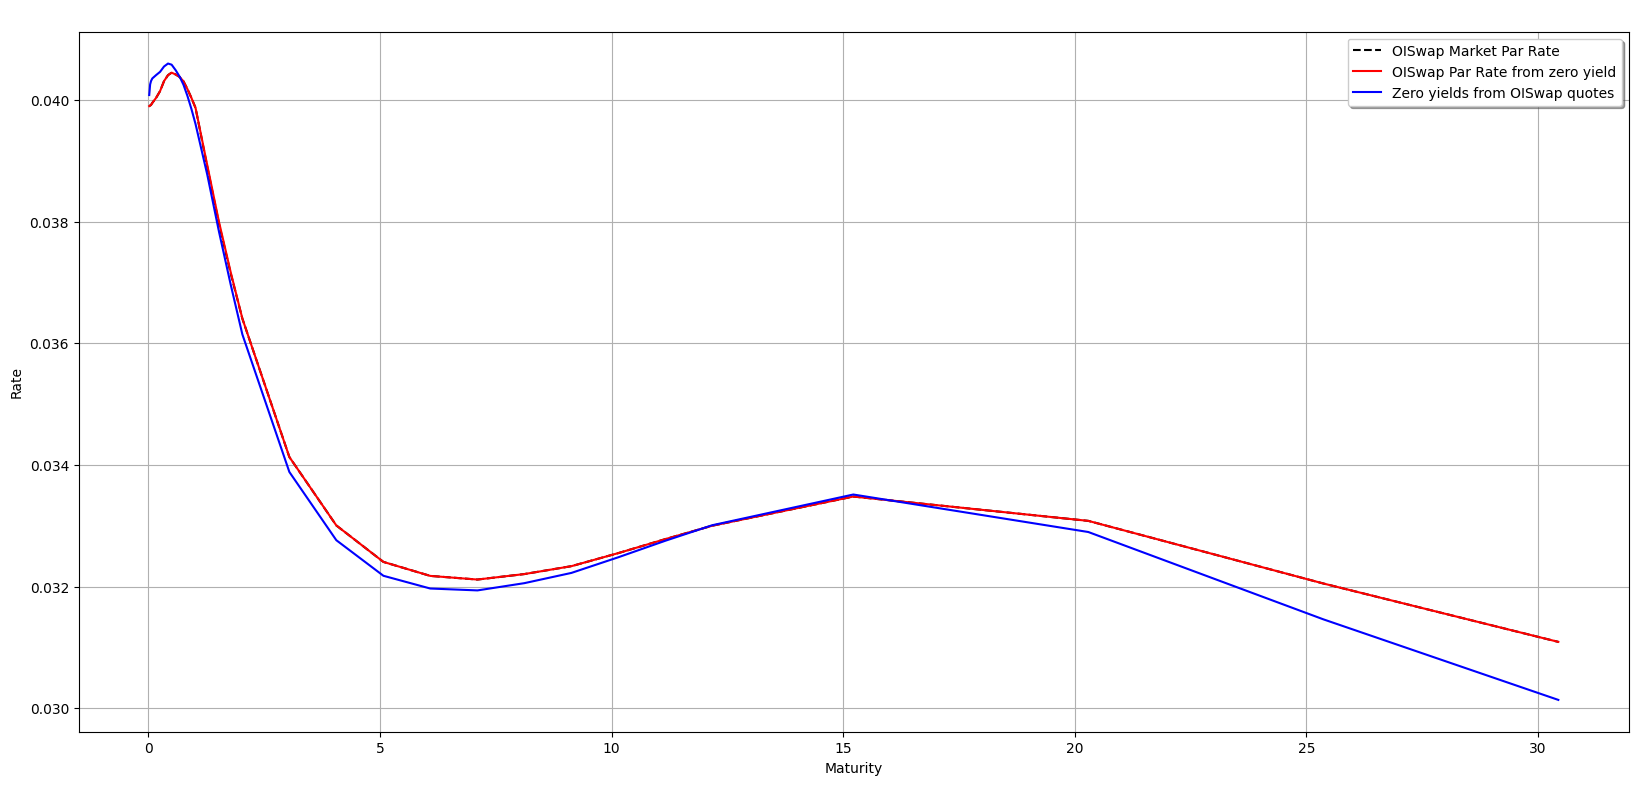

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(211)
ax.grid(True)

yearFracsOIS = [ql.Actual360().yearFraction(today,mat) 
             for mat in [ ql.TARGET().adjust(today + x, ql.Following) 
             for x in [ql.Period(item.numTimeUnits,item.timeUnit) 
             for item in mdata.oiSwapQuotes]]]

yearFracsOIS = md.get_year_frac(today, md.makeDataFrame(mdata.oiSwapQuotes)['Maturity'],ql.ModifiedFollowing)

ax.plot(yearFracsOIS, [item.rate for item in mdata.oiSwapQuotes],'k--', label='OISwap Market Par Rate')
ax.plot(yearFracsOIS, [priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1] for item in mdata.oiSwapQuotes],'k', label='OISwap Par Rate from zero yield',color ='red')
ax.plot(yearFracsOIS, [- math.log(oisZeroYields.discount(yf, True))/yf for yf in yearFracsOIS] ,'k', label='Zero yields from OISwap quotes',color ='blue')
ax.set_xlabel('Maturity') 
ax.set_ylabel('Rate')
legend = ax.legend(loc='upper right', shadow=True)
ax.set_title(" ", fontdict=None, loc=u'center')

# Compate discountfactors from BB with Quantlib

In [12]:


wb = openpyxl.load_workbook("CurvesfromBB/EUR.OIS.xlsx")
ws = wb.get_sheet_by_name('BView DC (linear_s)')
bblist = ReadExcel.get_list_from_cols(['Term','Df.Mid'],ws) 
bbzeroyield = []

for item in bblist:      
            numSettlementDays =0
            matchResult = re.match("([0-9]{1,2}) ([a-zA-Z][a-zA-Z])", item['Term'], flags=0)
            if(matchResult):
                timeUnit = md.map_BBtenor_to_quantlib(matchResult.group(2))
                numTimeUnits = int(matchResult.group(1))
                rate = item['Df.Mid']*100
                bbzeroyield.append(md.Datum(numSettlementDays,timeUnit,numTimeUnits,rate/100))
            else:
                print("Could not parse " + item['InstType'] + ' ' + 'Term' + ": " +item['Term'] )

yfData =[]
dfData=[]
error =[]
for item in sorted (mdata.oiSwapQuotes, key = lambda item : ql.Period(item.numTimeUnits,item.timeUnit)):
       term = md.printOISwapDatum(item,4)
       yf = ql.Actual360().yearFraction(today,ql.TARGET().adjust(today + ql.Period(item.numTimeUnits,item.timeUnit), ql.Following)) 
       yfData.append(yf)
       df = [bbitem.rate for bbitem in bbzeroyield if ((item.numTimeUnits == bbitem.numTimeUnits)&(item.timeUnit == bbitem.timeUnit))][0]
       dfData.append(df)
       err = df - oisZeroYields.discount(yf, True)
       error.append(err)
       print("Market: " + term + ':  ')
       print("   Discount Factor:    " + str(oisZeroYields.discount(yf, True)))       
       print("   BB Discount Factor: " + str(df))
       print("   Error: " + str(err))

C:\Users\fhoefer\AppData\Local\Temp\ipykernel_32644\1216167024.py:2:DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Market: Maturity: 1W	Quoted Rate:3.9900 %:  
   Discount Factor:    0.9992209238701704
   BB Discount Factor: 1.000011
   Error: 0.0007900761298296199
Market: Maturity: 2W	Quoted Rate:3.9910 %:  
   Discount Factor:    0.9984356383732598
   BB Discount Factor: 1.000028
   Error: 0.0015923616267401464


IndexError: list index out of range

C:\Users\fhoefer\AppData\Local\Temp\ipykernel_17092\2829573211.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(yfData, dfData,'k--', label='BB Discount Factors', color ='green')
C:\Users\fhoefer\AppData\Local\Temp\ipykernel_17092\2829573211.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(yfData, [oisZeroYields.discount(yf, True) for yf in yfData] ,'k', label='QuantLib Discount Factors',color ='blue')


Text(0.5, 1.0, ' ')

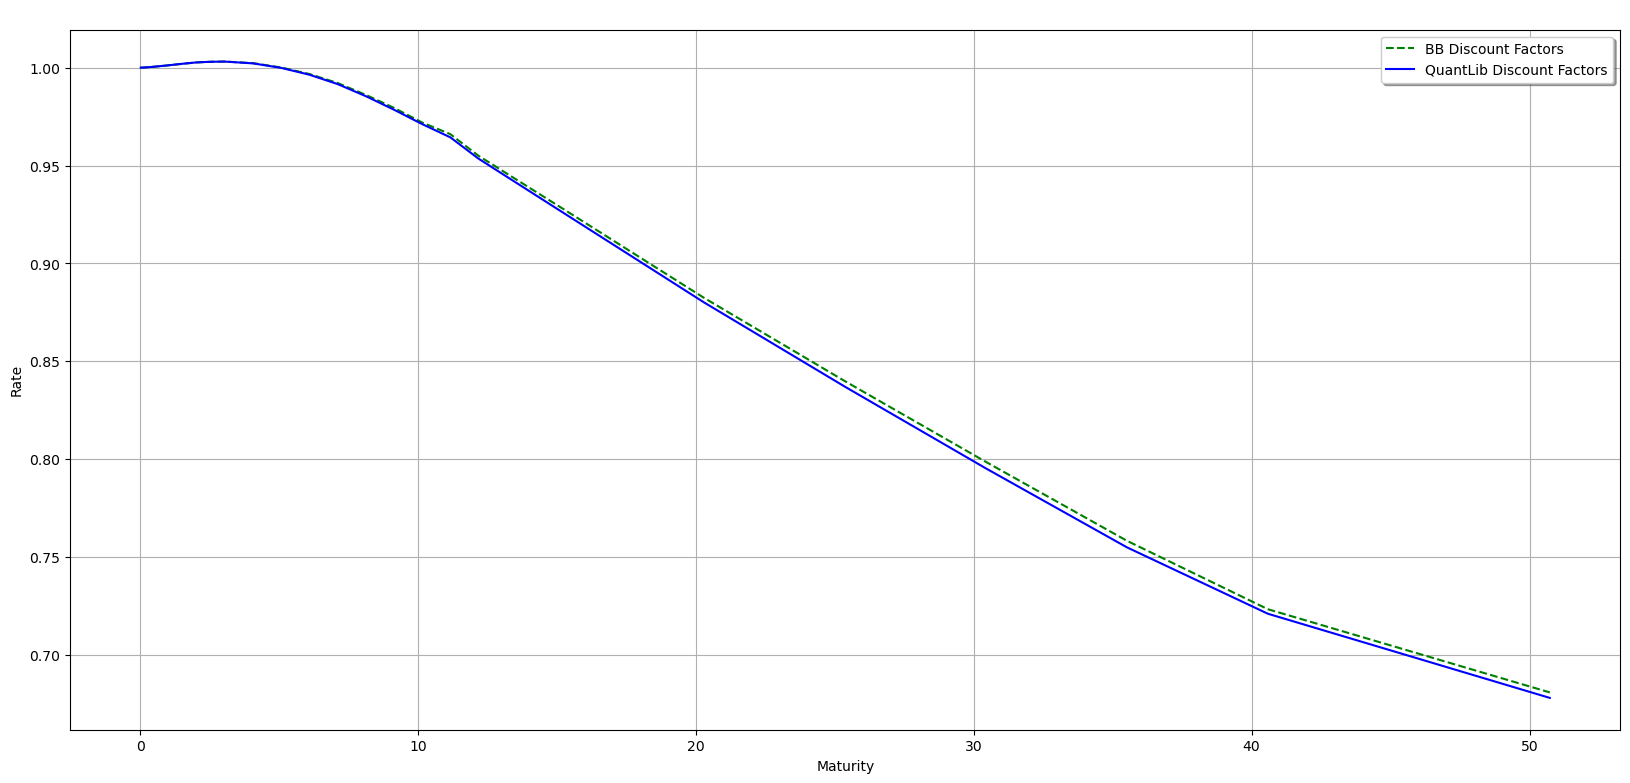

In [ ]:
fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(211)
ax2.grid(True)

yearFracsOIS = [ql.Actual360().yearFraction(today,mat) 
             for mat in [ ql.TARGET().adjust(today + x, ql.Following) 
             for x in [ql.Period(item.numTimeUnits,item.timeUnit) 
             for item in mdata.oiSwapQuotes]]]

ax2.plot(yfData, dfData,'k--', label='BB Discount Factors', color ='green')
ax2.plot(yfData, [oisZeroYields.discount(yf, True) for yf in yfData] ,'k', label='QuantLib Discount Factors',color ='blue')
ax2.set_xlabel('Maturity') 
ax2.set_ylabel('Rate')
legend = ax2.legend(loc='upper right', shadow=True)
ax2.set_title(" ", fontdict=None, loc=u'center')

# TODO

The first three instruments are three 1-day deposit that give us discounting between today and the day after spot. They are modeled by three instances of the DepositRateHelper class, with a tenor of 1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit starting on the spot date).

In [24]:
EURDEPO_chain = rd.content.pricing.chain.Definition(name='EURDEPO=').get_stream()
EURDEPO_chain.open(False)
euroDepoQuotes = rd.get_data(universe=EURDEPO_chain.constituents, fields=['GV4_TEXT', 'MATUR_DATE', 'PRIMACT_1', 'SEC_ACT_1'])
euroDepoQuotes

,Instrument,GV4_TEXT,MATUR_DATE,PRIMACT_1,SEC_ACT_1
0,/EUROND=,ON,2023-10-02,3.85,4.04
1,/EURTND=,TN,2023-10-03,3.85,4.04
2,/EURSND=,SN,2023-10-04,3.85,4.05
3,/EURSWD=,SW,2023-10-10,3.85,4.04
4,/EUR2WD=,2W,2023-10-17,3.85,4.05
5,/EUR3WD=,3W,2023-10-24,3.85,4.04
6,/EUR1MD=,1M,2023-11-03,3.9,4.09
7,/EUR2MD=,2M,2023-12-04,3.8,4.15
8,/EUR3MD=,3M,2024-01-03,3.8,4.15
9,/EUR4MD=,4M,2024-02-05,4.04,4.09


In [39]:
oiSwap = [md.Datum(0 if row["Instrument"] == '/EUROND=' else 1 if row["Instrument"] == '/EURTND=' else 2,                        
                        md.map_RTRtenor_to_quantlib_period(row["GV4_TEXT"].strip()).units(),
                        md.map_RTRtenor_to_quantlib_period(row["GV4_TEXT"].strip()).length(),
                        (row["PRIMACT_1"]+row["SEC_ACT_1"]) /200) for index,row in euroDepoQuotes[:3].iterrows()]
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(datum.rate / 100)),
        ql.Period(datum.timeUnit,datum.numTimeUnits),
        datum.numSettlementDays,
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for datum in oiSwap
]

[Maturity: 1W	Quoted Rate:3.9450 %,
 Maturity: 1W	Quoted Rate:3.9450 %,
 Maturity: 1W	Quoted Rate:3.9500 %]

In [53]:
eonia = ql.Eonia()
helpers += [
    ql.OISRateHelper(
        2, ql.Period(*tenor), ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, tenor in [
        (0.070, (1, ql.Weeks)),
        (0.069, (2, ql.Weeks)),
        (0.078, (3, ql.Weeks)),
        (0.074, (1, ql.Months)),
    ]
]

Then, we have a series of OIS quotes for the first month. They are modeled by instances of the OISRateHelper class with varying tenors. They also require an instance of the Eonia class, which doesn’t need a forecast curve and can be shared between the helpers.

Another note: there are examples floating around the web (and, until recently, in our own examples) in which the index passed to the helpers is instantiated by passing it a RelinkableYieldTermStructureHandle, and the handle is later linked to the curve we’re bootstrapping. Don’t do that. It will create a cycle between objects and result in a memory leak. When we have the curve, we’ll use it to create another instance of the index.

In [54]:
helpers += [
    ql.DatedOISRateHelper(
        start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, start_date, end_date in [
        (0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
        (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
        (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
        (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
        (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013)),
    ]
]

Next, five OIS forwards on ECB dates. For these, we need to instantiate the DatedOISRateHelper class and specify start and end dates explicitly.

In [55]:
helpers += [
    ql.DatedOISRateHelper(
        start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, start_date, end_date in [
        (0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
        (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
        (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
        (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
        (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013)),
    ]
]